In [1]:
import os
import nibabel as nib

import scipy.io as scio
import numpy as np
import matplotlib.pyplot as plt

import utils.compressed_sensing as cs
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F

from utils.dataset import *
from utils.model import *

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

dict_keys(['__header__', '__version__', '__globals__', 'seq'])
(256, 256, 30)


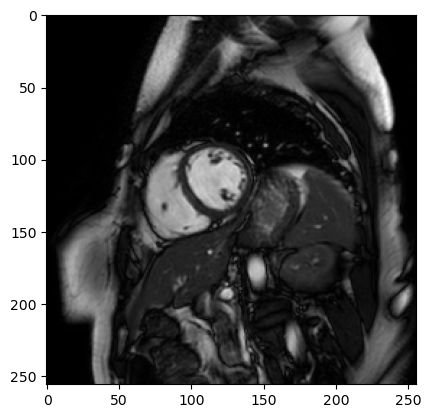

In [2]:
import scipy.io as scio

test = scio.loadmat('data/cardiac.mat')
print(test.keys())
seq = test['seq']
print(seq.shape)

plt.imshow(np.abs(seq[:,:,-1]), cmap='gray')

In [3]:
files = ['data/brain/brain_singlecoil_train.mat', 'data/knee/knee_singlecoil_train.mat']
dataset = universal_data(files, 5)
universal_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

0 (1, 256, 256) brain
1 (1, 256, 256) knee
2 (1, 256, 256) brain


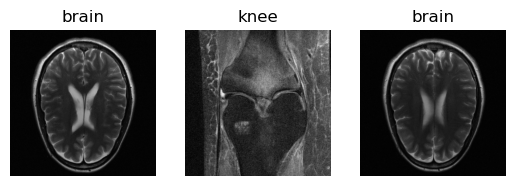

In [4]:
fig, ax = plt.subplots(1, 3)

for idx, data in enumerate(dataset):
    iu,ku,mask,i,k,a = data
    print(idx, i.shape, a)
    ax[idx].imshow(np.abs(i[0]), cmap='gray')
    ax[idx].axis('off')
    ax[idx].set_title(a)
    if idx == 2:
        break

# Test Universal LDA on brain dataset

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PSNR_list = []
SSIM_list = []
anatomies = ['brain', 'knee']
n_phase = 15
#model = Universal_LDA(n_block=n_phase, anatomies=anatomies)
#model.to(device)
#model.load_state_dict(torch.load('universal_LDA/universal/checkpoints/checkpoint.pth')['state_dict'])
brain_dataset = anatomy_data('data/brain/brain_singlecoil_test.mat', acc=5, n=200, mask='cartesian')
brain_loader = DataLoader(brain_dataset, batch_size=1, shuffle=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
with torch.no_grad():
    anatomy=('brain',)
    for i, data in enumerate(brain_loader):
        # undersampled image, k-space, mask, original image, original k-space
        im_und, k_und, mask, img_gnd, k_gnd = data
        # print(im_und.shape, k_und.shape, mask.shape, img_gnd.shape, k_gnd.shape)
        im_und = im_und.to(device)
        k_und = k_und.to(device)
        mask = mask.to(device)
        img_gnd = img_gnd.to(device)
        k_gnd = k_gnd.to(device)    
        # forward pass
        output = model(im_und, k_und, mask, anatomy[0])
        output = torch.abs(output[-1]).clamp(0, 1)
        img_gnd = torch.abs(img_gnd)
        

        p = psnr(np.abs(output[0].squeeze().cpu().detach().numpy()), img_gnd[0].squeeze().cpu().detach().numpy(), data_range=1)
        s = ssim(np.abs(output[0].squeeze().cpu().detach().numpy()), img_gnd[0].squeeze().cpu().detach().numpy(), data_range=1)
        PSNR_list.append(p)
        SSIM_list.append(s)
        print("psnr: ", p, "ssim: ", s)
        
        
print("average psnr: ", np.mean(PSNR_list))
print("average ssim: ", np.mean(SSIM_list))

psnr:  36.030757362873366 ssim:  0.959744596113205
psnr:  35.84534707661789 ssim:  0.9503388136014939
psnr:  34.614653783453676 ssim:  0.9647106395125389
psnr:  37.05720703493966 ssim:  0.951795888976574
psnr:  36.760534904909676 ssim:  0.9533961688504219
psnr:  36.57800784377522 ssim:  0.9569766927189827
psnr:  31.74023876169532 ssim:  0.8425762976665497
psnr:  38.1411662821895 ssim:  0.9693540017261505
psnr:  38.90304166608209 ssim:  0.9702395722837448
psnr:  40.020363899586435 ssim:  0.9739830500354767
psnr:  32.05801514924921 ssim:  0.9192598846757412
psnr:  42.80999996684058 ssim:  0.9771314386758805
psnr:  37.19392626594889 ssim:  0.9600108212556839
psnr:  38.59708814064744 ssim:  0.9683465344209671
psnr:  35.13961833383944 ssim:  0.9678293556089401
psnr:  41.98775139181105 ssim:  0.9713268279561996
psnr:  33.29547084905292 ssim:  0.9289582369143963
psnr:  42.176180690638475 ssim:  0.9772008770895004
psnr:  38.97692200686855 ssim:  0.9736220131568909
psnr:  43.265237493432224 ssi

# Compare with anatomic-specific LDA

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PSNR_list = []
SSIM_list = []
anatomies = ['brain', 'knee']
n_phase = 15
brain_model = LDA(n_block=n_phase, channel_num=16)
brain_model.to(device)
brain_model.load_state_dict(torch.load('universal_LDA/brain/checkpoints_10_sampling_radial/checkpoint.pth'))
brain_dataset = anatomy_data('data/brain/brain_singlecoil_test.mat', acc=10, n=200, mask='radial')
brain_loader = DataLoader(brain_dataset, batch_size=1, shuffle=True)

In [6]:
from utils.model1 import Mamba_LDA

In [7]:
mamba_brain_LDA = Mamba_LDA(n_block=n_phase, channel_num=16)
mamba_brain_LDA.to(device)
mamba_brain_LDA.load_state_dict(torch.load('universal_LDA/brain/checkpoints_Mamba_10_sampling_radial_inexact/checkpoint.pth')['state_dict'])

<All keys matched successfully>

In [11]:
with torch.no_grad():
    anatomy=('brain',)
    for i, data in enumerate(brain_loader):
        # undersampled image, k-space, mask, original image, original k-space
        im_und, k_und, mask, img_gnd, k_gnd = data
        # print(im_und.shape, k_und.shape, mask.shape, img_gnd.shape, k_gnd.shape)
        im_und = im_und.to(device)
        k_und = k_und.to(device)
        mask = mask.to(device)
        img_gnd = img_gnd.to(device)
        k_gnd = k_gnd.to(device)    
        # forward pass
        output = brain_model(im_und, k_und, mask)
        output = torch.abs(output[-1]).clamp(0, 1)
        img_gnd = torch.abs(img_gnd)
        

        p = psnr(np.abs(output[0].squeeze().cpu().detach().numpy()), img_gnd[0].squeeze().cpu().detach().numpy(), data_range=1)
        s = ssim(np.abs(output[0].squeeze().cpu().detach().numpy()), img_gnd[0].squeeze().cpu().detach().numpy(), data_range=1)
        PSNR_list.append(p)
        SSIM_list.append(s)
        print("psnr: ", p, "ssim: ", s)
        
        
print("average psnr: ", np.mean(PSNR_list))
print("average ssim: ", np.mean(SSIM_list))

psnr:  28.509741669763944 ssim:  0.7235064229114055
psnr:  38.78622269317885 ssim:  0.9673899306383132
psnr:  37.57686035283253 ssim:  0.9698982472906112
psnr:  33.967688721898 ssim:  0.920669377887249
psnr:  37.9589340821767 ssim:  0.9555077988171577
psnr:  39.23117457752185 ssim:  0.9677319114494324
psnr:  35.641301268782975 ssim:  0.9613667098722458
psnr:  34.44895880566855 ssim:  0.9257839286847115
psnr:  34.67537127174215 ssim:  0.9451126265211105
psnr:  34.0486263532768 ssim:  0.9333721606683731
psnr:  37.65334933271173 ssim:  0.9497239275183678
psnr:  35.96144615282728 ssim:  0.9539399160842895
psnr:  33.88889009693568 ssim:  0.9546112653746605
psnr:  29.501241975859255 ssim:  0.7641456192421913
psnr:  33.915957978841114 ssim:  0.9530835144729615
psnr:  34.363668261957905 ssim:  0.9494091686630249
psnr:  35.10649795474769 ssim:  0.9463684908404351
psnr:  38.809288505592036 ssim:  0.9664206778659821
psnr:  35.82879496375745 ssim:  0.9507115593485832
psnr:  36.964938988471076 ssim

In [8]:
with torch.no_grad():
    anatomy=('brain',)
    for i, data in enumerate(brain_loader):
        # undersampled image, k-space, mask, original image, original k-space
        im_und, k_und, mask, img_gnd, k_gnd = data
        # print(im_und.shape, k_und.shape, mask.shape, img_gnd.shape, k_gnd.shape)
        im_und = im_und.to(device)
        k_und = k_und.to(device)
        mask = mask.to(device)
        img_gnd = img_gnd.to(device)
        k_gnd = k_gnd.to(device)    
        # forward pass
        output = mamba_brain_LDA(im_und, k_und, mask)
        output = torch.abs(output[-1]).clamp(0, 1)
        img_gnd = torch.abs(img_gnd)
        

        p = psnr(np.abs(output[0].squeeze().cpu().detach().numpy()), img_gnd[0].squeeze().cpu().detach().numpy(), data_range=1)
        s = ssim(np.abs(output[0].squeeze().cpu().detach().numpy()), img_gnd[0].squeeze().cpu().detach().numpy(), data_range=1)
        PSNR_list.append(p)
        SSIM_list.append(s)
        print("psnr: ", p, "ssim: ", s)
        
        
print("average psnr: ", np.mean(PSNR_list))
print("average ssim: ", np.mean(SSIM_list))

psnr:  37.93630903360799 ssim:  0.9637775695943832
psnr:  38.24109390605078 ssim:  0.9634490843262672
psnr:  33.344263314962895 ssim:  0.9149725285649299
psnr:  35.06178816057256 ssim:  0.96352983087492
psnr:  33.88381865413678 ssim:  0.9535623082003594
psnr:  38.17884553071421 ssim:  0.9565239802322387
psnr:  35.867126156628906 ssim:  0.9606865005207061
psnr:  32.09613200478052 ssim:  0.9039636201028823
psnr:  39.857539141014044 ssim:  0.9685875991621018
psnr:  39.60173652356711 ssim:  0.9615313261537551
psnr:  40.110133545744596 ssim:  0.9695792642335892
psnr:  32.40156729212836 ssim:  0.8145454328253269
psnr:  35.08231804186196 ssim:  0.9422935520472526
psnr:  33.06174018019138 ssim:  0.8153193781690597
psnr:  33.489261071871525 ssim:  0.9334202546839714
psnr:  34.39957344321286 ssim:  0.9243589996657372
psnr:  28.724909731667935 ssim:  0.7245853010689021
psnr:  29.330323419387977 ssim:  0.821912407874465
psnr:  34.1553953827622 ssim:  0.9227772739138603
psnr:  37.17737710144883 ssi

# Test Universal LDA on knee dataset

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PSNR_list = []
SSIM_list = []
#anatomies = ['brain', 'knee']
n_phase = 15
#model = Universal_LDA(n_block=n_phase, anatomies=anatomies)
#model.to(device)
#model.load_state_dict(torch.load('universal_LDA/universal/checkpoints/checkpoint.pth'))
knee_dataset = anatomy_data('data/knee/knee_singlecoil_test.mat', acc=5, n=200)
knee_loader = DataLoader(knee_dataset, batch_size=1, shuffle=True)

In [7]:
with torch.no_grad():
    anatomy=('knee',)
    for i, data in enumerate(knee_loader):
        # undersampled image, k-space, mask, original image, original k-space
        im_und, k_und, mask, img_gnd, k_gnd = data
        # print(im_und.shape, k_und.shape, mask.shape, img_gnd.shape, k_gnd.shape)
        im_und = im_und.to(device)
        k_und = k_und.to(device)
        mask = mask.to(device)
        img_gnd = img_gnd.to(device)
        k_gnd = k_gnd.to(device)    
        # forward pass
        output = model(im_und, k_und, mask, anatomy[0])
        output = torch.abs(output[-1]).clamp(0, 1)
        img_gnd = torch.abs(img_gnd)
        

        p = psnr(np.abs(output[0].squeeze().cpu().detach().numpy()), img_gnd[0].squeeze().cpu().detach().numpy(), data_range=1)
        s = ssim(np.abs(output[0].squeeze().cpu().detach().numpy()), img_gnd[0].squeeze().cpu().detach().numpy(), data_range=1)
        PSNR_list.append(p)
        SSIM_list.append(s)
        print("psnr: ", p, "ssim: ", s)
        
        
print("average psnr: ", np.mean(PSNR_list))
print("average ssim: ", np.mean(SSIM_list))

psnr:  35.59652548566095 ssim:  0.8937764011497498
psnr:  30.93499038430314 ssim:  0.7523157007169724
psnr:  32.996696848956304 ssim:  0.8230588805894852
psnr:  34.94997026623422 ssim:  0.9045834644393921
psnr:  35.276939603885076 ssim:  0.8828454286928177
psnr:  35.96057572141557 ssim:  0.9011717210235596
psnr:  34.12594461697704 ssim:  0.8547588797483444
psnr:  30.4917522214458 ssim:  0.7134111973729134
psnr:  37.8980057198425 ssim:  0.9285808705501556
psnr:  31.424406300118193 ssim:  0.7868686576671601
psnr:  29.822543987774715 ssim:  0.7460073702273369
psnr:  28.686065112316427 ssim:  0.7108288970322609
psnr:  32.22922803866476 ssim:  0.7799835721459388
psnr:  30.520189294151542 ssim:  0.7914505320024491
psnr:  28.669551980667034 ssim:  0.6778850827860832
psnr:  29.41258802390527 ssim:  0.8327131535861492
psnr:  35.46962054886515 ssim:  0.9073200700798034
psnr:  29.52475176586889 ssim:  0.7887688977689743
psnr:  31.400929858987222 ssim:  0.7738183777132034
psnr:  37.72133616266475 

# Compare with Knee LDA

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PSNR_list = []
SSIM_list = []
anatomies = ['brain', 'knee']
n_phase = 15
knee_model = LDA(n_block=n_phase)
knee_model.to(device)
knee_model.load_state_dict(torch.load('universal_LDA/knee/checkpoints/checkpoint.pth'))
knee_dataset = anatomy_data('data/knee/knee_singlecoil_test.mat', acc=5, n=200)
knee_loader = DataLoader(knee_dataset, batch_size=1, shuffle=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
with torch.no_grad():
    anatomy=('brain',)
    for i, data in enumerate(knee_loader):
        # undersampled image, k-space, mask, original image, original k-space
        im_und, k_und, mask, img_gnd, k_gnd = data
        # print(im_und.shape, k_und.shape, mask.shape, img_gnd.shape, k_gnd.shape)
        im_und = im_und.to(device)
        k_und = k_und.to(device)
        mask = mask.to(device)
        img_gnd = img_gnd.to(device)
        k_gnd = k_gnd.to(device)    
        # forward pass
        output = knee_model(im_und, k_und, mask)
        output = torch.abs(output[-1]).clamp(0, 1)
        img_gnd = torch.abs(img_gnd)
        

        p = psnr(np.abs(output[0].squeeze().cpu().detach().numpy()), img_gnd[0].squeeze().cpu().detach().numpy(), data_range=1)
        s = ssim(np.abs(output[0].squeeze().cpu().detach().numpy()), img_gnd[0].squeeze().cpu().detach().numpy(), data_range=1)
        PSNR_list.append(p)
        SSIM_list.append(s)
        print("psnr: ", p, "ssim: ", s)
        
        
print("average psnr: ", np.mean(PSNR_list))
print("average ssim: ", np.mean(SSIM_list))

psnr:  40.022976700215466 ssim:  0.9468336992120743
psnr:  33.58280279245972 ssim:  0.8262725094075203
psnr:  30.576202347106975 ssim:  0.7557392612128258
psnr:  38.03012157373536 ssim:  0.916249667878151
psnr:  31.525498910829093 ssim:  0.7718376854491233
psnr:  30.86167086189061 ssim:  0.7832058319330215
psnr:  34.61862191794088 ssim:  0.8915478843493462
psnr:  35.91905717021007 ssim:  0.9072663738622665
psnr:  35.64610322293197 ssim:  0.8610180202226638
psnr:  30.54940196255548 ssim:  0.764808919377327
psnr:  28.760096663571243 ssim:  0.7177918795394898
psnr:  39.0982468470692 ssim:  0.938577277586937
psnr:  33.307233643077645 ssim:  0.8275070591788292
psnr:  30.037817036128324 ssim:  0.8519686869292259
psnr:  36.417322046971805 ssim:  0.9010061510190964
psnr:  30.388974801241353 ssim:  0.7368880596723556
psnr:  38.08840966870122 ssim:  0.926368250699997
psnr:  28.76746141699286 ssim:  0.7172271507735253
psnr:  32.462476757690865 ssim:  0.7871566388378143
psnr:  30.713639260339356 s

# Test Transfered Universal LDA on cardiac dataset

In [14]:
cardiac_dataset = anatomy_data('data/cardiac/cardiac_singlecoil_test.mat', acc=5, n=200)
cardiac_loader = DataLoader(cardiac_dataset, batch_size=1, shuffle=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PSNR_list = []
SSIM_list = []
anatomies = ['brain', 'knee', 'cardiac']
n_phase = 15
model = Universal_LDA(n_block=n_phase, anatomies=anatomies, channel_num=16)
model.to(device)
#model.load_state_dict(torch.load('universal_LDA/universal/checkpoints_5_sampling_cartesian/checkpoint.pth')['state_dict'], strict=False)
model.load_state_dict(torch.load('universal_LDA/cardiac/checkpoints_transfer_5_sampling_cartesian_data_2.5_%/checkpoint.pth')['state_dict'])
# model.load_state_dict(torch.load('universal_LDA/cardiac/checkpoints_universal/checkpoint.pth')['state_dict'])

<All keys matched successfully>

In [15]:
model.set_PhaseNo(6)

with torch.no_grad():
    anatomy=('cardiac',)
    for i, data in enumerate(brain_loader):
        # undersampled image, k-space, mask, original image, original k-space
        im_und, k_und, mask, img_gnd, k_gnd = data
        # print(im_und.shape, k_und.shape, mask.shape, img_gnd.shape, k_gnd.shape)
        im_und = im_und.to(device)
        k_und = k_und.to(device)
        mask = mask.to(device)
        img_gnd = img_gnd.to(device)
        k_gnd = k_gnd.to(device)    
        # forward pass
        output = model(im_und, k_und, mask, anatomy[0])
        output = torch.abs(output[-1]).clamp(0, 1)
        img_gnd = torch.abs(img_gnd)
        

        p = psnr(np.abs(output[0].squeeze().cpu().detach().numpy()), img_gnd[0].squeeze().cpu().detach().numpy(), data_range=1)
        s = ssim(np.abs(output[0].squeeze().cpu().detach().numpy()), img_gnd[0].squeeze().cpu().detach().numpy(), data_range=1)
        PSNR_list.append(p)
        SSIM_list.append(s)
        print("psnr: ", p, "ssim: ", s)
        
        
print("average psnr: ", np.mean(PSNR_list))
print("average ssim: ", np.mean(SSIM_list))

psnr:  32.218037651222666 ssim:  0.906600680891037
psnr:  33.44645397943969 ssim:  0.9414027704546452
psnr:  33.8246031047482 ssim:  0.9253473884193897
psnr:  32.056618633663724 ssim:  0.9241018700315654
psnr:  35.75853915610648 ssim:  0.9429011340694428
psnr:  33.8038616475214 ssim:  0.9454680094485283
psnr:  34.63271328049847 ssim:  0.9135185728273392
psnr:  36.43820200432999 ssim:  0.9423500461053849
psnr:  36.40649133287789 ssim:  0.9450168737897873
psnr:  33.168454147405605 ssim:  0.9459365775570869
psnr:  33.53865423847501 ssim:  0.9323100616984368
psnr:  31.311845672457586 ssim:  0.9321184473075866
psnr:  32.06803475837821 ssim:  0.9031303698692322
psnr:  33.78050801115067 ssim:  0.9390332646148205
psnr:  32.83367001014436 ssim:  0.933479225461483
psnr:  32.12059695047714 ssim:  0.9353131310757995
psnr:  38.09331856809936 ssim:  0.9490653498630524
psnr:  38.7326529052294 ssim:  0.9486790040326119
psnr:  34.64295083714055 ssim:  0.9346056123552322
psnr:  32.12145114156617 ssim:  

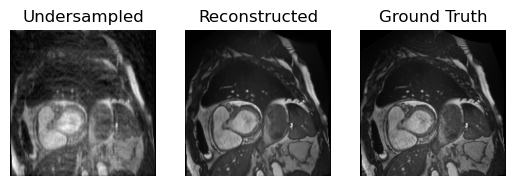

In [3]:
# plot results
fig, ax = plt.subplots(1, 3)
for i, data in enumerate(cardiac_loader):
    im_und, k_und, mask, img_gnd, k_gnd = data
    im_und = im_und.to(device)
    k_und = k_und.to(device)
    mask = mask.to(device)
    img_gnd = img_gnd.to(device)
    k_gnd = k_gnd.to(device)    
    output = model(im_und, k_und, mask, anatomy[0])
    output = torch.abs(output[-1]).clamp(0, 1)
    img_gnd = torch.abs(img_gnd)
    ax[0].imshow(np.abs(im_und[0].squeeze().cpu().detach().numpy()), cmap='gray')
    ax[0].axis('off')
    ax[0].set_title('Undersampled')
    ax[1].imshow(np.abs(output[0].squeeze().cpu().detach().numpy()), cmap='gray')
    ax[1].axis('off')
    ax[1].set_title('Reconstructed')
    ax[2].imshow(np.abs(img_gnd[0].squeeze().cpu().detach().numpy()), cmap='gray')
    ax[2].axis('off')
    ax[2].set_title('Ground Truth')
    break

# Compare with cardiac LDA

In [9]:
cardiac_LDA = LDA(n_block=15)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cardiac_LDA.to(device)
cardiac_LDA.load_state_dict(torch.load('universal_LDA/cardiac/checkpoints/checkpoint.pth'))

<All keys matched successfully>

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PSNR_list = []
SSIM_list = []
#anatomies = ['brain', 'knee']
n_phase = 15
#model = Universal_LDA(n_block=n_phase, anatomies=anatomies)
#model.to(device)
#model.load_state_dict(torch.load('universal_LDA/universal/checkpoints/checkpoint.pth'))
knee_dataset = anatomy_data('data/cardiac/cardiac_singlecoil_test.mat', acc=5, n=200)
knee_loader = DataLoader(knee_dataset, batch_size=1, shuffle=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
with torch.no_grad():
    anatomy=('knee',)
    for i, data in enumerate(knee_loader):
        # undersampled image, k-space, mask, original image, original k-space
        im_und, k_und, mask, img_gnd, k_gnd = data
        # print(im_und.shape, k_und.shape, mask.shape, img_gnd.shape, k_gnd.shape)
        im_und = im_und.to(device)
        k_und = k_und.to(device)
        mask = mask.to(device)
        img_gnd = img_gnd.to(device)
        k_gnd = k_gnd.to(device)    
        # forward pass
        output = cardiac_LDA(im_und, k_und, mask)
        output = torch.abs(output[-1]).clamp(0, 1)
        img_gnd = torch.abs(img_gnd)
        

        p = psnr(np.abs(output[0].squeeze().cpu().detach().numpy()), img_gnd[0].squeeze().cpu().detach().numpy(), data_range=1)
        s = ssim(np.abs(output[0].squeeze().cpu().detach().numpy()), img_gnd[0].squeeze().cpu().detach().numpy(), data_range=1)
        PSNR_list.append(p)
        SSIM_list.append(s)
        print("psnr: ", p, "ssim: ", s)
        
        
print("average psnr: ", np.mean(PSNR_list))
print("average ssim: ", np.mean(SSIM_list))

psnr:  33.15706454334412 ssim:  0.9105647994446755
psnr:  31.259603091049723 ssim:  0.9170574616528601
psnr:  33.43312560820409 ssim:  0.9372260106644631
psnr:  35.677146252308034 ssim:  0.9493496801214218
psnr:  35.20010191466997 ssim:  0.9497269647359848
psnr:  30.871434761392862 ssim:  0.8625228424218446
psnr:  36.395551249597474 ssim:  0.9507316446356774
psnr:  34.380168592830884 ssim:  0.9204239339931011
psnr:  36.215832084702434 ssim:  0.9444451889266968
psnr:  35.5098739462168 ssim:  0.9367574816595912
psnr:  35.344032797774744 ssim:  0.9416988345193863
psnr:  29.902235292244136 ssim:  0.866724743533492
psnr:  34.34704264195973 ssim:  0.9156275437312126
psnr:  32.90397301270994 ssim:  0.9105835203590393
psnr:  32.54875590105413 ssim:  0.913772666501999
psnr:  35.72620916322286 ssim:  0.9515873061628342
psnr:  32.91280068375461 ssim:  0.9315702841773034
psnr:  34.604358314854395 ssim:  0.9238691373243332
psnr:  32.59596319117582 ssim:  0.9199181750760078
psnr:  35.34942586163255 

# Compare with Phase 15 and Phase 6 Transfered Universal LDA on cardiac dataset

In [16]:
#cardiac_dataset = anatomy_data('data/cardiac/cardiac_singlecoil_test.mat', acc=5, n=200)
#cardiac_loader = DataLoader(cardiac_dataset, batch_size=1, shuffle=False)

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PSNR_list = []
SSIM_list = []
anatomies = ['brain', 'knee', 'cardiac']
n_phase = 15
model = Universal_LDA(n_block=n_phase, anatomies=anatomies)
model.to(device)
# model.load_state_dict(torch.load('universal_LDA/universal/checkpoints/checkpoint.pth')['state_dict'],)
model.load_state_dict(torch.load('universal_LDA/cardiac/checkpoints_universal_6/checkpoint_7.pth')['state_dict'])

<All keys matched successfully>

In [18]:
model.set_PhaseNo(6)
with torch.no_grad():
    anatomy=('cardiac',)
    for i, data in enumerate(cardiac_loader):
        # undersampled image, k-space, mask, original image, original k-space
        im_und, k_und, mask, img_gnd, k_gnd = data
        # print(im_und.shape, k_und.shape, mask.shape, img_gnd.shape, k_gnd.shape)
        im_und = im_und.to(device)
        k_und = k_und.to(device)
        mask = mask.to(device)
        img_gnd = img_gnd.to(device)
        k_gnd = k_gnd.to(device)    
        # forward pass
        output = model(im_und, k_und, mask, anatomy[0])
        output = torch.abs(output[-1]).clamp(0, 1)
        img_gnd = torch.abs(img_gnd)
        

        p = psnr(np.abs(output[0].squeeze().cpu().detach().numpy()), img_gnd[0].squeeze().cpu().detach().numpy(), data_range=1)
        s = ssim(np.abs(output[0].squeeze().cpu().detach().numpy()), img_gnd[0].squeeze().cpu().detach().numpy(), data_range=1)
        PSNR_list.append(p)
        SSIM_list.append(s)
        print("psnr: ", p, "ssim: ", s)
        
        
print("average psnr: ", np.mean(PSNR_list))
print("average ssim: ", np.mean(SSIM_list))

psnr:  34.517074242794415 ssim:  0.9109074278223515
psnr:  33.440900295996144 ssim:  0.8888631869804859
psnr:  35.113653777475854 ssim:  0.9341125319738388
psnr:  36.54738191546138 ssim:  0.9456972419610024
psnr:  35.22997269956097 ssim:  0.9380146014857292
psnr:  32.80132900111987 ssim:  0.9092727007336616
psnr:  34.64630486884761 ssim:  0.9302514904971123
psnr:  36.56249147843597 ssim:  0.9466588021664619
psnr:  35.38834888188696 ssim:  0.9511511222586632
psnr:  35.50312647621978 ssim:  0.952139274128437
psnr:  33.85337544411095 ssim:  0.921199893799305
psnr:  31.01276753439854 ssim:  0.8734449406355917
psnr:  33.84009554543736 ssim:  0.9323755637111664
psnr:  34.15021183099199 ssim:  0.9401601950588226
psnr:  35.85104043986616 ssim:  0.9375342214941979
psnr:  34.55928886600774 ssim:  0.92905791655159
psnr:  36.21116748028261 ssim:  0.9468429685640335
psnr:  33.98297410071755 ssim:  0.9296948403449059
psnr:  34.954052261970446 ssim:  0.9240632117562294
psnr:  36.44409946145579 ssim: 

In [19]:
model.load_state_dict(torch.load('universal_LDA/cardiac/checkpoints_universal_6/checkpoint.pth')['state_dict'])
model.set_PhaseNo(15)
with torch.no_grad():
    anatomy=('cardiac',)
    for i, data in enumerate(cardiac_loader):
        # undersampled image, k-space, mask, original image, original k-space
        im_und, k_und, mask, img_gnd, k_gnd = data
        # print(im_und.shape, k_und.shape, mask.shape, img_gnd.shape, k_gnd.shape)
        im_und = im_und.to(device)
        k_und = k_und.to(device)
        mask = mask.to(device)
        img_gnd = img_gnd.to(device)
        k_gnd = k_gnd.to(device)    
        # forward pass
        output = model(im_und, k_und, mask, anatomy[0])
        output = torch.abs(output[-1]).clamp(0, 1)
        img_gnd = torch.abs(img_gnd)
        

        p = psnr(np.abs(output[0].squeeze().cpu().detach().numpy()), img_gnd[0].squeeze().cpu().detach().numpy(), data_range=1)
        s = ssim(np.abs(output[0].squeeze().cpu().detach().numpy()), img_gnd[0].squeeze().cpu().detach().numpy(), data_range=1)
        PSNR_list.append(p)
        SSIM_list.append(s)
        print("psnr: ", p, "ssim: ", s)
        
        
print("average psnr: ", np.mean(PSNR_list))
print("average ssim: ", np.mean(SSIM_list))

psnr:  33.50445384496906 ssim:  0.9024377669479251
psnr:  35.291509687481195 ssim:  0.9266983916742801
psnr:  37.20861782968892 ssim:  0.9585402232632637
psnr:  35.81286387490295 ssim:  0.9429540743098259
psnr:  33.4996766335869 ssim:  0.9157101661212445
psnr:  33.215806397967896 ssim:  0.9201102818856239
psnr:  36.876652566419594 ssim:  0.9595758908529282
psnr:  38.34148882773115 ssim:  0.9642887217874527
psnr:  32.88275330242219 ssim:  0.9277885815639496
psnr:  33.66307849224894 ssim:  0.9349282117094994
psnr:  35.31318942421946 ssim:  0.9299900424346924
psnr:  31.755737618534695 ssim:  0.871561389111273
psnr:  31.883066517332864 ssim:  0.911310345459938
psnr:  32.853313658644396 ssim:  0.9306104097099305
psnr:  34.91960832389467 ssim:  0.9441944453282356
psnr:  35.378499721199674 ssim:  0.943233151714325
psnr:  32.58982683098162 ssim:  0.9137327080503702
psnr:  34.2100339788592 ssim:  0.931039767257452
psnr:  35.70403733586567 ssim:  0.937461710144043
psnr:  36.44757021607174 ssim: 